# Tutorial: tutorial_plot_reduced_spectra

This function allows you to plot the reduced spectra that go into the spectroscopic analysis

In [ ]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import os
import sys
from pathlib import Path

In [66]:
try:
    sobject_id = int(sys.argv[1])
    try:
        if int(sys.argv[2]) == 0:
            rv_shifting = False
        if sys.argv[2] == 'False':
            rv_shifting = False
    except:
        rv_shifting = True
    try:
        if int(sys.argv[3]) == 0:
            save_fig = False
        if sys.argv[3] == 'False':
            save_fig = False
    except:
        save_fig = True
    try:
        if int(sys.argv[3]) == 0:
            plot_lines = False
        if sys.argv[3] == 'False':
            plot_lines = False
    except:
        plot_lines = True
except:
    sobject_id = 220809000601301 # 140209002701031 # 140111002101186 # 140111002101094 # 131216001601275 # 140117002101010
    rv_shifting = False
    save_fig = True
    plot_lines = False

galah_dr4_directory = os.path.abspath(os.getcwd()+'/../')+'/'

print('Will plot reduced spectrum for '+str(sobject_id))
print('Assuming to operate out of github GALAH DR4 repitory structure')
print('Files will be read in relative to '+galah_dr4_directory)

print('\nTo prepare for cases of missing line-spread functions (LSF),')
print('we will also need to read in the initial values table to find the next-best LSF.')
print('Assuming galah_dr4_initial_parameters_220714_lite.fits to be at spectrum_analysis/')

init_values_table = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_230101_lite.fits')
sobject_id_initial_index = np.where(init_values_table['sobject_id'] == sobject_id)[0]
if len(sobject_id_initial_index) == 0:
    print('\nNo entry in initial catalogue found! Populating placeholders')
    values_table = Table()
    for key in init_values_table.keys():
        if key == 'sobject_id':
            values_table[key] = [sobject_id]
        elif type(init_values_table[key][0]) == str:
            values_table[key] = ['None']
        elif type(init_values_table[key][0]) in [np.int64,np.int32,np.int16,int]:
            values_table[key] = -1
        elif type(init_values_table[key][0]) in [np.float64,np.float32,float]:
            values_table[key] = -1
        elif key == 'res':
            pass
        else:
            print(key)
    sobject_id_initial_index = 0
    init_values_table = values_table
else:
    if len(sobject_id_initial_index) > 1:
        print('\nMultiple entries in initial catalogue found!')
    sobject_id_initial_index = sobject_id_initial_index[0]

spectrum = dict()
spectrum['sobject_id'] = sobject_id

Will plot reduced spectrum for 220809000601301
Assuming to operate out of github GALAH DR4 repitory structure
Files will be read in relative to /avatar/buder/GALAH_DR4/

To prepare for cases of missing line-spread functions (LSF),
we will also need to read in the initial values table to find the next-best LSF.
Assuming galah_dr4_initial_parameters_220714_lite.fits to be at spectrum_analysis/


# 1) Read in the spectrum

In [67]:
expected_crval_cdelt_ranges = dict()

for ccd in [1,2,3,4]:
    for cindex, key in enumerate(['CRVAL1','CDELT1']):
        
        if key == 'CRVAL1':
            if ccd == 1:
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p1'] = 4711.5
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p99'] = 4715.5
            if ccd == 2:
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p1'] = 5646.7
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p99'] = 5650.7
            if ccd == 3:
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p1'] = 6475.8
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p99'] = 6480.5
            if ccd == 4:
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p1'] = 7583.5
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p99'] = 7587.5
        if key == 'CDELT1':
            if ccd == 1:
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.04591
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.04605
            if ccd == 2:
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.0545
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.0548
            if ccd == 3:
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.06303
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.063215
            if ccd == 4:
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.07342
                expected_crval_cdelt_ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.07367

In [68]:
def read_spectrum(sobject_id, spectrum):

    fits_file = fits.open(galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')
    if fits_file[0].header['SLITMASK'] in ['IN','IN      ']:
        spectrum['resolution'] = 'high-res'
        print('Warning: Spectrum is high-resolution!')
    else:
        spectrum['resolution'] = 'low-res'

    if fits_file[0].header['WAV_OK']==0:
        print('Warning: Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        print('Warning: Cross-talk not calculated reliably!')

    spectrum['vrad_red'] = fits_file[0].header['RVCOM']

    spectrum['plate'] = int(fits_file[0].header['PLATE'])
    
    # This is a test if the CCD is actually available. For 181221001601377, CCD4 is missing for example.
    # We therefore implement a keyword 'available_ccds' to trigger only to loop over the available CCDs
    spectrum['available_ccds'] = []
    
    for ccd in [1,2,3,4]:
        
        try:

            if ccd != 1:
                fits_file = fits.open(galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

            spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
            spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

            spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
            counts_relative_uncertainty = fits_file[2].data

            bad_counts_unc = np.where(~(counts_relative_uncertainty > 0) == True)[0]
            if len(bad_counts_unc) > 0:
                if sys.argv[1] == '-f': print('Relative counts uncertainties <= 0 detected for '+str(len(bad_counts_unc))+' pixels in CCD'+str(ccd)+', setting to 0.1 (SNR~10)')
                counts_relative_uncertainty[bad_counts_unc] = 0.1

            spectrum['counts_unc_ccd'+str(ccd)] = counts_relative_uncertainty * fits_file[0].data

            spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
            spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

            spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
            spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data

            spectrum['available_ccds'].append(ccd)
        except:
            pass

        if ccd in spectrum['available_ccds']:
            if np.shape(spectrum['lsf_ccd'+str(ccd)])[0] == 1:

                # find all spectra are
                # a) observed with same FIBRE (*pivot*) and
                # b) observed with the same PLATE (*plate*) 
                # c) have a measured LSF in the particular CCD
                # d) have the same resolution setup (low- or high-res)
                if spectrum['resolution'] != 'high-res':
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == init_values_table['pivot']) & 
                            (spectrum['plate'] == init_values_table['plate']) &
                            (init_values_table['res'][:,ccd-1] > 0) & 
                            (init_values_table['reduction_flags'] < 262144)
                        )==True)[0]
                else:
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == init_values_table['pivot']) & 
                            (spectrum['plate'] == init_values_table['plate']) &
                            (init_values_table['res'][:,ccd-1] > 0) & 
                            (init_values_table['reduction_flags'] >= 262144)
                        )==True)[0]

                # Difference between observing runs == abs(sobject_id - all possible sobject_ids)
                sobject_id_differences = np.abs(spectrum['sobject_id'] - init_values_table['sobject_id'][same_fibre_plate_ccd_and_has_res_profile])
                # Now find the closest observing run
                closest_valid_sobject_id_index = np.argmin(sobject_id_differences)
                closest_valid_sobject_id = init_values_table['sobject_id'][same_fibre_plate_ccd_and_has_res_profile][closest_valid_sobject_id_index]

                lsf_replacement_fits_file = fits.open(galah_dr4_directory+'observations/'+str(closest_valid_sobject_id)[:6]+'/spectra/com/'+str(closest_valid_sobject_id)+str(ccd)+'.fits')
                spectrum['lsf_b_ccd'+str(ccd)] = lsf_replacement_fits_file[0].header['B']
                spectrum['lsf_ccd'+str(ccd)]   = lsf_replacement_fits_file[7].data
                lsf_replacement_fits_file.close()

                if sys.argv[1] == '-f': print('No LSF reported for CCD'+str(ccd)+'. Replaced LSF and LSF-B for CCD '+str(ccd)+' with profile from '+str(closest_valid_sobject_id))

        fits_file.close()

    for ccd in [1,2,3]:
        
        if (spectrum['crval_ccd'+str(ccd)] < expected_crval_cdelt_ranges['CRVAL1_ccd'+str(ccd)+'_p1']):
            print('CRVAL CCD'+str(ccd)+' out of expected range. Shifting up to median value from '+"{:.1f}".format(spectrum['crval_ccd'+str(ccd)]))
            spectrum['crval_ccd'+str(ccd)] = 0.5*(expected_crval_cdelt_ranges['CRVAL1_ccd'+str(ccd)+'_p1'] + expected_crval_cdelt_ranges['CRVAL1_ccd'+str(ccd)+'_p99'])
        if (spectrum['crval_ccd'+str(ccd)] > expected_crval_cdelt_ranges['CRVAL1_ccd'+str(ccd)+'_p99']):
            print('CRVAL CCD'+str(ccd)+' out of expected range. Shifting up to median value from '+"{:.1f}".format(spectrum['crval_ccd'+str(ccd)]))
            spectrum['crval_ccd'+str(ccd)] = 0.5*(expected_crval_cdelt_ranges['CRVAL1_ccd'+str(ccd)+'_p1'] + expected_crval_cdelt_ranges['CRVAL1_ccd'+str(ccd)+'_p99'])
        if (spectrum['cdelt_ccd'+str(ccd)] < expected_crval_cdelt_ranges['CDELT1_ccd'+str(ccd)+'_p1']):
            print('DELT CCD'+str(ccd)+' out of expected range. Shifting up to median value from '+"{:.1f}".format(spectrum['crval_ccd'+str(ccd)]))
            spectrum['cdelt_ccd'+str(ccd)] = 0.5*(expected_crval_cdelt_ranges['CDELT1_ccd'+str(ccd)+'_p1'] + expected_crval_cdelt_ranges['CDELT1_ccd'+str(ccd)+'_p99'])
        if (spectrum['cdelt_ccd'+str(ccd)] > expected_crval_cdelt_ranges['CDELT1_ccd'+str(ccd)+'_p99']):
            print('CDELT CCD'+str(ccd)+' out of expected range. Shifting up to median value from '+"{:.1f}".format(spectrum['crval_ccd'+str(ccd)]))
            spectrum['cdelt_ccd'+str(ccd)] = 0.5*(expected_crval_cdelt_ranges['CDELT1_ccd'+str(ccd)+'_p1'] + expected_crval_cdelt_ranges['CDELT1_ccd'+str(ccd)+'_p99'])
        
        below_zero = np.where(spectrum['counts_ccd'+str(ccd)] <= 0)[0]
        if len(below_zero) > 50:
            if below_zero[0] == 0:
                print('CCD'+str(ccd)+' has '+str(len(below_zero))+' pixels <= 0 at it its beginning')
                print(below_zero)
                #wave_ccd = spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)] * np.arange(len(spectrum['counts_ccd'+str(ccd)]))
                #not_zero = np.arange(np.where(spectrum['counts_ccd'+str(ccd)] <= 0)[0][-1]+20,len(spectrum['counts_ccd'+str(ccd)]))
                #spectrum['crval_ccd'+str(ccd)] = wave_ccd[not_zero][0]
                #spectrum['counts_ccd'+str(ccd)] = spectrum['counts_ccd2'][not_zero]
                #spectrum['counts_unc_ccd'+str(ccd)] = spectrum['counts_unc_ccd2'][not_zero]
                #spectrum['lsf_ccd'+str(ccd)] = spectrum['lsf_ccd'+str(ccd)][not_zero]

    spectrum['wave'] = np.array(np.concatenate(([spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)] * np.arange(len(spectrum['counts_ccd'+str(ccd)])) for ccd in spectrum['available_ccds']])))
    spectrum['counts'] = np.array(np.concatenate(([spectrum['counts_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])))
    spectrum['counts_unc'] = np.array(np.concatenate(([spectrum['counts_unc_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])))

    return(spectrum)

spectrum = read_spectrum(sobject_id, spectrum)

In [69]:
def load_dr3_lines(mode_dr3_path = './spectrum_masks/important_lines'):
    """
    Load important lines to guide the observer where the information is for certain elements
    """
    important_lines = [
        [4861.3230,r'H$_\beta$',r'H$_\beta$'],
        [6562.7970,r'H$_\alpha$',r'H$_\alpha$']
    ]
    
    important_molecules = [
        [4710,4740,'Mol. C2','Mol. C2'],
        [7594,7695,'Mol. O2 (tell.)','Mol. O2 (tell.)']
        ]

    line, wave = np.loadtxt(galah_dr4_directory+'spectrum_analysis/spectrum_masks/important_lines',usecols=(0,1),unpack=True,dtype=str, comments=';')

    for each_index in range(len(line)):
        if line[each_index] != 'Sp':
            if len(line[each_index]) < 5:
                important_lines.append([float(wave[each_index]), line[each_index], line[each_index]])
            else:
                important_lines.append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
        
    return(important_lines,important_molecules)

important_lines, important_molecules = load_dr3_lines()

In [70]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements,
    
    Assuming speed of light is 299792.458 km/s
    as given by
    import astropy.constants as c
    import astropy.units as u
    c.c.to(u.km/u.s).value
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/299792.458)

In [71]:
def plot_reduced_spectrum(wave_not_shifted,flux,flux_uncertainty,rv_value,text_line1,text_line2,text_line3):
    """
    Let's plot the spectrum, that is, flux over wavelenth (the latter shifted by the rv_value)
    
    We will plot 12 different subplot ranges (3 for each CCD) to allow better assessment of the results
    
    INPUT:
    wave_not_shifted : 1D-array with N pixels
    flux : 1D-array with N pixels or (M,N)-array with N pixels for M spectra (e.g. M = 2 for observed and synthetic spectrum)
    flux_uncertainty : 1D-array with N pixels
    rv_value : float value of RV to be applied to wave_not_shifted
    """
    
    # Let's define the wavelength beginnings and ends for each suplot
    subplot_wavelengths = np.array([
        [4710,4775],
        [4770,4850],
        [4840,4905],
        [5645,5730],
        [5720,5805],
        [5795,5878],
        [6470,6600],
        [6590,6670],
        [6660,6739],
        [7577,7697],
        [7677,7720],
        [7710,7820],
        [7810,7890]
    ])

    # How many subplots will we need?
    nr_subplots = np.shape(subplot_wavelengths)[0]
    
    f, gs = plt.subplots(nr_subplots,1,figsize=(8.3,11.7))
    
    try:
        # test if several spectra fed into flux
        dummy = np.shape(flux)[1] == len(wave)
        flux_array_indices = np.shape(flux)[0]
        flux = np.array(flux)
    except:
        flux_array_indices = 1
        
    if rv_shifting:
        wave_rv_shifted = rv_shift(rv_value, wave_not_shifted)
    else:
        wave_rv_shifted = wave_not_shifted

    # Let's loop over the subplots
    for subplot in range(nr_subplots):
        
        # Which part of the observed/model spectrum is in our subplot wavelength range?
        in_subplot_wavelength_range = (wave_rv_shifted > subplot_wavelengths[subplot,0]) & (wave_rv_shifted < subplot_wavelengths[subplot,1])

        ax = gs[subplot]
        ax.set_xlim(subplot_wavelengths[subplot,0],subplot_wavelengths[subplot,1])
        
        if len(wave_rv_shifted[in_subplot_wavelength_range]) > 0:
            
            # if only 1 spectrum
            if flux_array_indices == 1:
                ax.fill_between(
                    wave_rv_shifted[in_subplot_wavelength_range],
                    flux[in_subplot_wavelength_range] - flux_uncertainty[in_subplot_wavelength_range],
                    flux[in_subplot_wavelength_range] + flux_uncertainty[in_subplot_wavelength_range],
                    color = 'grey', alpha = 0.5
                );
                ax.plot(wave_rv_shifted[in_subplot_wavelength_range],flux[in_subplot_wavelength_range],lw=0.5,c='k',label='data');
                
            else:
                for index in range(flux_array_indices):
                    if index == 0:
                        ax.plot(wave_rv_shifted[in_subplot_wavelength_range],flux[0,in_subplot_wavelength_range],lw=0.5,c='k',label='data');
                        ax.plot(wave_rv_shifted[in_subplot_wavelength_range],1.05 + flux_uncertainty[in_subplot_wavelength_range],lw=0.5,c='C3',label='scatter');
                    if index == 1:
                        ax.plot(wave_rv_shifted[in_subplot_wavelength_range],flux[index,in_subplot_wavelength_range],lw=0.5,c='r',label='model (optimised)');
                        ax.plot(wave_rv_shifted[in_subplot_wavelength_range],1.05 + np.abs(flux[0,in_subplot_wavelength_range]-flux[index,in_subplot_wavelength_range]),lw=0.5,c='C4',label='residuals');
                if subplot == nr_subplots-1:
                    ax.legend(ncol=2,loc='lower right',fontsize=6)
        else:
            ax.set_ylim(-0.1,1.2)

        if flux_array_indices == 1:
            percentiles = np.percentile(flux[in_subplot_wavelength_range],q=[1,99])
        else:
            percentiles = np.percentile(flux[0,in_subplot_wavelength_range],q=[1,99])
        if percentiles[0] > 0:
            ylim = (0,1.1*percentiles[1])
        else:
            ylim = percentiles[0],1.1*percentiles[1]
        ax.set_ylim(ylim)

        each_index = 0 
        if plot_lines:
            for each_element in important_lines:
                if (each_element[0] > subplot_wavelengths[subplot,0]) & (each_element[0] < subplot_wavelengths[subplot,1]):

                    offset = -0.05+0.1*(each_index%3)
                    each_index+=1
                    ax.axvline(each_element[0],lw=0.2,ls='dashed',c='r')
                    if each_element[1] in ['Li','C','O']:
                        ax.text(each_element[0],ylim[0]+offset*(ylim[1]-ylim[0]),each_element[1],fontsize=10,ha='center',color='pink')
                    elif each_element[1] in ['Mg','Si','Ca','Ti','Ti2']:
                        ax.text(each_element[0],ylim[0]+offset*(ylim[1]-ylim[0]),each_element[1],fontsize=10,ha='center',color='b')
                    elif each_element[1] in ['Na','Al','K']:
                        ax.text(each_element[0],ylim[0]+offset*(ylim[1]-ylim[0]),each_element[1],fontsize=10,ha='center',color='orange')
                    elif each_element[1] in ['Sc','V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']:
                        ax.text(each_element[0],ylim[0]+offset*(ylim[1]-ylim[0]),each_element[1],fontsize=10,ha='center',color='brown')
                    elif each_element[1] in ['Rb', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Ce','Mo','Ru', 'Nd', 'Sm','Eu']:
                        ax.text(each_element[0],ylim[0]+offset*(ylim[1]-ylim[0]),each_element[1],fontsize=10,ha='center',color='purple')

        if subplot == 0:
            color = 'k'
            if (
                (spectrum['crval_ccd1'] < expected_crval_cdelt_ranges['CRVAL1_ccd1_p1']) |
                (spectrum['crval_ccd1'] > expected_crval_cdelt_ranges['CRVAL1_ccd1_p99']) |
                (spectrum['cdelt_ccd1'] < expected_crval_cdelt_ranges['CDELT1_ccd1_p1']) |
                (spectrum['cdelt_ccd1'] > expected_crval_cdelt_ranges['CDELT1_ccd1_p99'])
            ):
                color = 'r'
            ax.text(4710.5,ylim[0]+0.7*(ylim[1]-ylim[0]),"{:.1f}".format(spectrum['crval_ccd1'])+','+"{:.5f}".format(spectrum['cdelt_ccd1']),bbox=dict(boxstyle='round', facecolor='w', alpha=0.5),color=color)
        if subplot == 3:
            color = 'k'
            if (
                (spectrum['crval_ccd2'] < expected_crval_cdelt_ranges['CRVAL1_ccd2_p1']) |
                (spectrum['crval_ccd2'] > expected_crval_cdelt_ranges['CRVAL1_ccd2_p99']) |
                (spectrum['cdelt_ccd2'] < expected_crval_cdelt_ranges['CDELT1_ccd2_p1']) |
                (spectrum['cdelt_ccd2'] > expected_crval_cdelt_ranges['CDELT1_ccd2_p99'])
            ):
                color = 'r'
            ax.text(5646,ylim[0]+0.7*(ylim[1]-ylim[0]),"{:.1f}".format(spectrum['crval_ccd2'])+','+"{:.5f}".format(spectrum['cdelt_ccd2']),bbox=dict(boxstyle='round', facecolor='w', alpha=0.5),color=color)
        if subplot == 6:
            color = 'k'
            if (
                (spectrum['crval_ccd3'] < expected_crval_cdelt_ranges['CRVAL1_ccd3_p1']) |
                (spectrum['crval_ccd3'] > expected_crval_cdelt_ranges['CRVAL1_ccd3_p99']) |
                (spectrum['cdelt_ccd3'] < expected_crval_cdelt_ranges['CDELT1_ccd3_p1']) |
                (spectrum['cdelt_ccd3'] > expected_crval_cdelt_ranges['CDELT1_ccd3_p99'])
            ):
                color = 'r'
            ax.text(6472,ylim[0]+0.7*(ylim[1]-ylim[0]),"{:.1f}".format(spectrum['crval_ccd3'])+','+"{:.5f}".format(spectrum['cdelt_ccd3']),bbox=dict(boxstyle='round', facecolor='w', alpha=0.5),color=color)
        if subplot == 9:
            color = 'k'
            if (
                (spectrum['crval_ccd4'] < expected_crval_cdelt_ranges['CRVAL1_ccd4_p1']) |
                (spectrum['crval_ccd4'] > expected_crval_cdelt_ranges['CRVAL1_ccd4_p99']) |
                (spectrum['cdelt_ccd4'] < expected_crval_cdelt_ranges['CDELT1_ccd4_p1']) |
                (spectrum['cdelt_ccd4'] > expected_crval_cdelt_ranges['CDELT1_ccd4_p99'])
            ):
                color = 'r'
            ax.text(7578,ylim[0]+0.7*(ylim[1]-ylim[0]),"{:.1f}".format(spectrum['crval_ccd4'])+','+"{:.5f}".format(spectrum['cdelt_ccd4']),bbox=dict(boxstyle='round', facecolor='w', alpha=0.5),color=color)
                    
        if subplot == nr_subplots-1:
            ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
        ax.set_ylabel('Counts')
    f.suptitle(text_line1+' \n '+text_line2+' \n '+text_line3)
    plt.tight_layout(h_pad=0)
    
    return f

In [72]:
info_line_1 = str(sobject_id)+' red_flag: '+str(int(init_values_table['reduction_flags'][sobject_id_initial_index]))

info_line_2 = 'Teff='+str(int(init_values_table['teff'][sobject_id_initial_index]))+'K, '+ \
    'logg='+str(np.round(init_values_table['logg'][sobject_id_initial_index],decimals=2))+', '+ \
    '[Fe/H]='+str(np.round(init_values_table['fe_h'][sobject_id_initial_index],decimals=2))+', '+ \
    'vmic='+str(np.round(init_values_table['vmic'][sobject_id_initial_index],decimals=2))+'km/s, '+ \
    'vsini='+str(np.round(init_values_table['vsini'][sobject_id_initial_index],decimals=1))+'km/s'

if not rv_shifting:
    info_line_3 = 'Used RV: 0 km/s'
else:
    info_line_3 = 'Used RV: '+str(np.round(init_values_table['vrad'][sobject_id_initial_index],decimals=2))+'km/s'
info_line_3 = info_line_3+', Red Pipe. = '
if np.isfinite(init_values_table['vrad_red'][sobject_id_initial_index]):
    info_line_3 = info_line_3+"{:.2f}".format(init_values_table['vrad_red'][sobject_id_initial_index])
else:
    info_line_3 = info_line_3+'NaN'
info_line_3 = info_line_3+', Gaia DR3 = '
if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
    info_line_3 = info_line_3+"{:.2f}".format(init_values_table['vrad_gaia'][sobject_id_initial_index])
else:
    info_line_3 = info_line_3+'NaN'

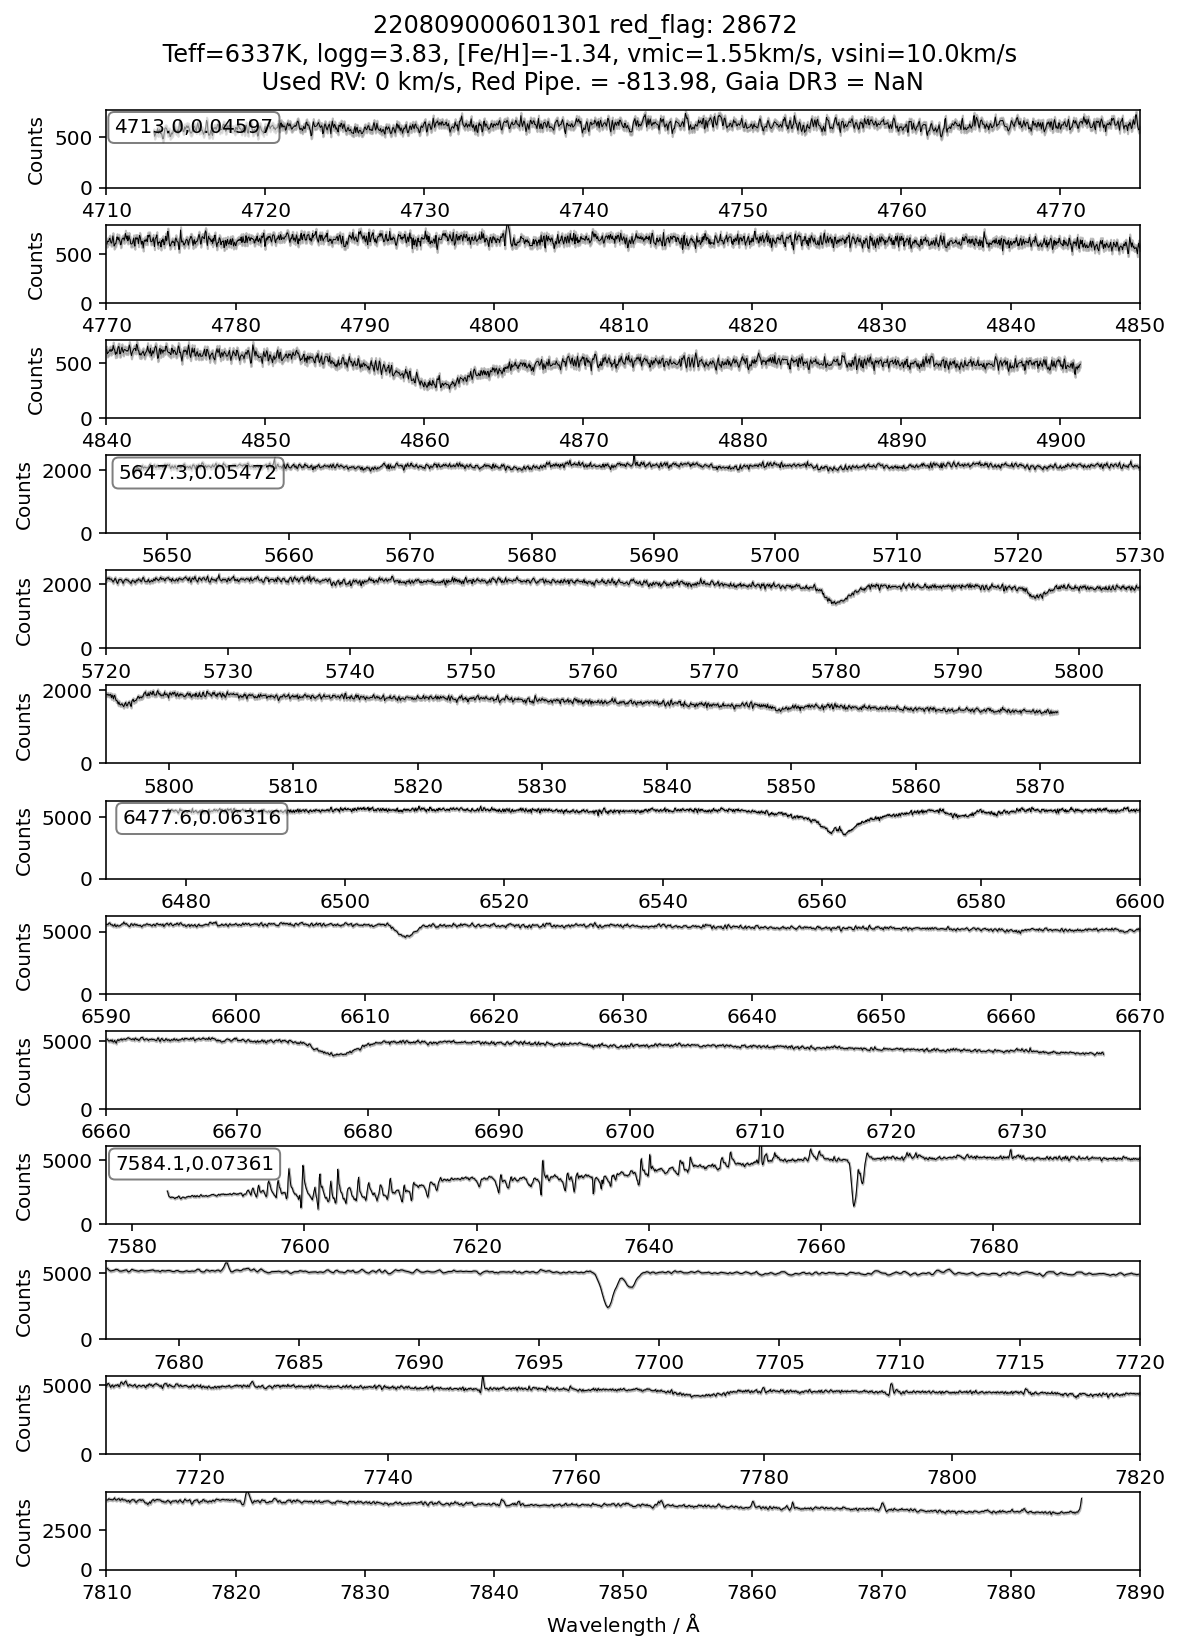

In [73]:
fig = plot_reduced_spectrum(
    spectrum['wave'],
    spectrum['counts'],
    spectrum['counts_unc'],
    init_values_table['vrad'][sobject_id_initial_index],
    info_line_1,
    info_line_2,
    info_line_3
)
if save_fig:
    file_directory = galah_dr4_directory+'/analysis_products/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'
    Path(file_directory).mkdir(parents=True, exist_ok=True)
    fig.savefig(file_directory+str(spectrum['sobject_id'])+'_single_fit_reduction_inspect.png',dpi=200,bbox_inches='tight')
if sys.argv[1] == '-f':
    plt.show()
plt.close()